# Detecting Anomalies

The purpose of this notebook is to detect abnormalities within a tensorboard scalar.

In [1]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

%matplotlib inline

from matplotlib import pyplot

In [2]:
import math

from src.utils import ExponentiallyWeightedMovingAverage

def get_running_mean_and_standard_deviation(steps, values, beta=0.9, sigma=8):
    """ Compute exponentially weighted running mean and standard deviation.
    
    Args:
        steps (list of float): Step at which each value occured.
        values (list of float): Values at each step.
        beta (float): Beta used to weight the exponential mean and standard deviation.
        sigma (float): Number of standard deviations before ignoring an abnormality.
        
    Returns:
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
    """
    assert len(values) == len(steps)
    
    stats = ExponentiallyWeightedMovingAverage(beta=beta)
    means, standard_deviations = [], []
    average, variance = 0.0, 0.0
    last_abnormality = 0
    eps = 10**-6
    for i, (step, value) in enumerate(zip(steps, values)):
        # Detected abnormality
        # NOTE: ``i < 1`` then ``variance == 0.0``
        # NOTE: Above a sample size 10, we do not need to consider sample variance bias correction
        if i > 10 and abs(value - means[-1]) > standard_deviations[-1] * sigma + eps:
            if i > last_abnormality + 100:
                print('Detected abnormality (%f > %f ± %f), at step %d (step ignored)' %
                      (value, means[-1], standard_deviations[-1] * sigma, step))
            last_abnormality = i
            means.append(means[-1])
            standard_deviations.append(standard_deviations[-1])
        else:
            average, standard_deviation = stats.step(value)
            means.append(average)
            standard_deviations.append(standard_deviation)
    return means, standard_deviations

def load_tensorboard_data(path):
    """ Load a CSV file with 3 columns: wall_time, step, value
    
    Args:
        path (str): Path to the CSV file.
    """
    print('Loading data...')
    data = [row for row in open(path, 'r')]
    print('Header:', data[0].strip())
    data = [tuple([float(val) for val in row.strip().split(',')]) for row in data[1:]]
    print('Sample:', data[:5])
    _, step, value = zip(*data)
    return step, value

def plot(steps, values, beta=0.9, sigma=8):
    """ Plot values at steps with a running mean and standard deviation.
    
    Args:
        step (list of float): Step at which each value occured.
        value (list of float): Values at each step.
        means (list of float, optional): Exponentially weighted running means for each step.
        standard_deviations (list of float, optional): Exponentially weighted running standard deviation for
            each step.
        sigma (float): Number of standard deviations before ignoring an abnormality.      
    """
    print('Loading steps from %d to %d' % (steps[0], steps[-1]))
    print('Sigma: %f' % sigma)
    print('Beta: %f' % beta)
    means, standard_deviations = get_running_mean_and_standard_deviation(steps,
                                                                         values,
                                                                         beta=beta,
                                                                         sigma=sigma)
    pyplot.figure(figsize=(20, 10))
    pyplot.style.use('ggplot')
    kwargs = {
        'marker': '.',
        'linestyle': 'solid'
    }
    pyplot.plot(steps, values, label='Value', **kwargs)
    pyplot.plot(steps, means, label='Mean', **kwargs)

    upper_bound = [value + sigma * sd for value, sd in zip(means, standard_deviations)]
    lower_bound = [value - sigma * sd for value, sd in zip(means, standard_deviations)]

    pyplot.plot(steps, upper_bound, label='Upper Bound', **kwargs)
    pyplot.plot(steps, lower_bound, label='Lower Bound', **kwargs)
    
    pyplot.legend()
    pyplot.ylabel('Value')
    pyplot.xlabel('Step')

In [3]:
coarse_loss = load_tensorboard_data(
    '/tmp/csv_output/data_tb___coarse_loss_epoch.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533666615.1496809, 634.0, 3.2326481342315674), (1533666671.3477118, 1169.0, 2.5975120067596436), (1533666726.9974222, 1703.0, 2.0253183841705322), (1533666782.5942597, 2233.0, 1.6927459239959717), (1533666838.5620012, 2770.0, 1.506052851676941)]


Loading steps from 634 to 935685
Sigma: 6.000000
Beta: 0.980000
Detected abnormality (0.000000 > 0.555130 ± 0.039876), at step 897821 (step ignored)


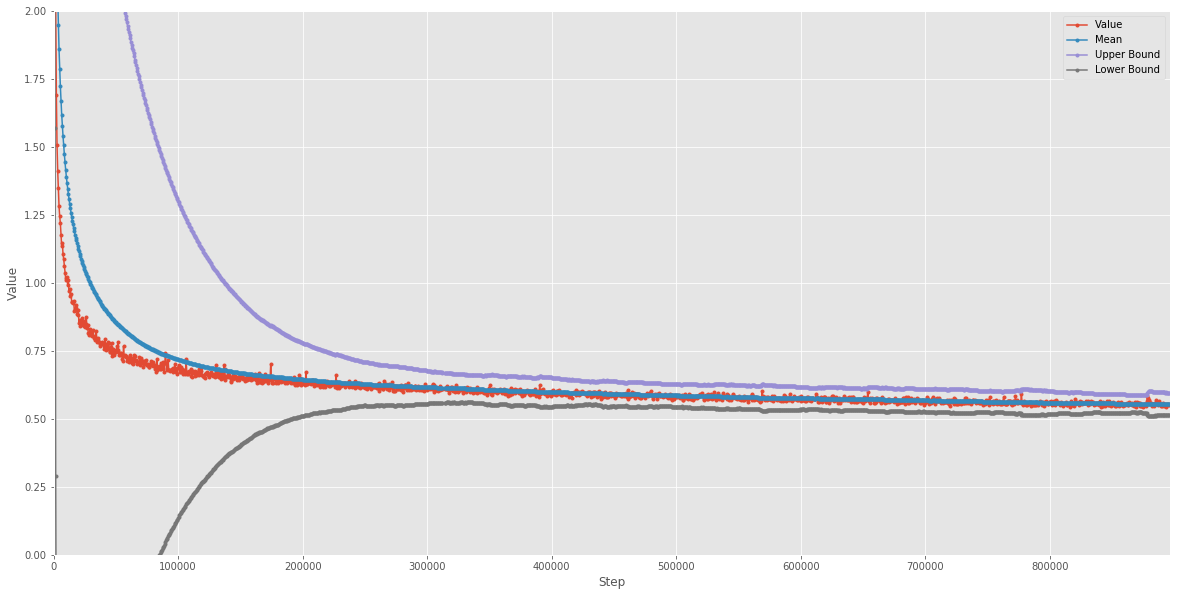

In [22]:
plot(*coarse_loss, sigma=6, beta=0.98)
_ = pyplot.axis([0, 896000, -0, 2])

In [9]:
max_grad_norm = load_tensorboard_data(
    '/tmp/csv_output/data_tb___max_grad_norm_step.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533666562.092194, 101.0, 0.956061840057373), (1533666562.4153175, 105.0, 1.0053952932357788), (1533666562.7366953, 108.0, 1.0547287464141846), (1533666563.0594943, 111.0, 1.40984308719635), (1533666563.3818448, 114.0, 1.7649574279785156)]


Loading steps from 101 to 902382
Sigma: 6.000000
Beta: 0.990000


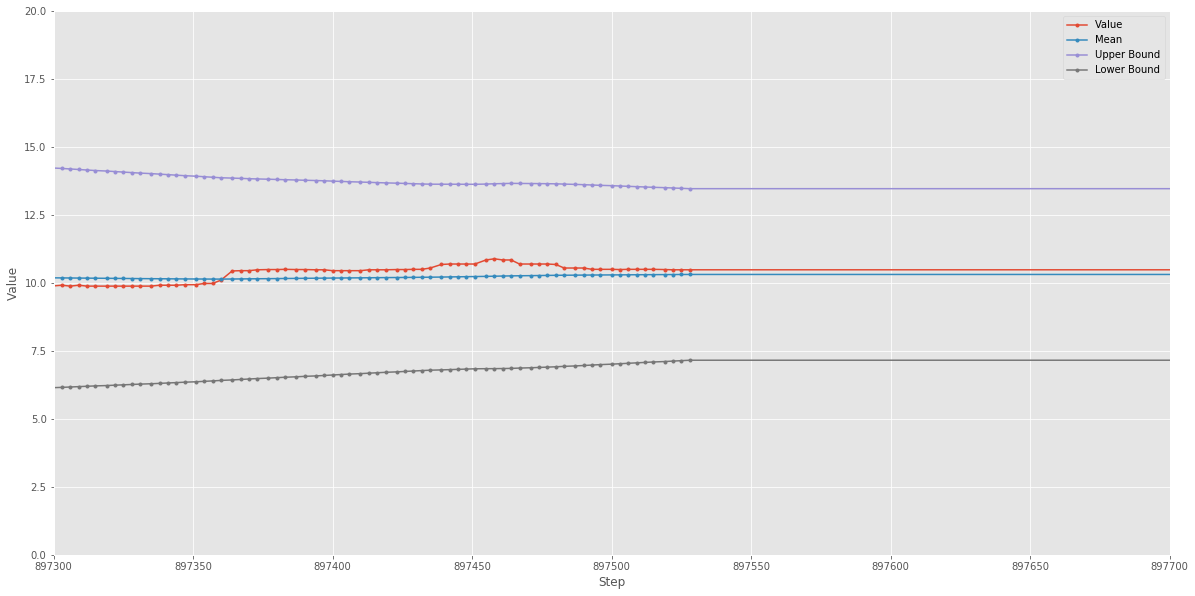

In [25]:
plot(*max_grad_norm, sigma=6, beta=0.99)
_ = pyplot.axis([897300, 897700, 0, 20])

In [18]:
parameter_norm = load_tensorboard_data(
    '/tmp/csv_output/data_tb___parameter_norm_step.csv')

Loading data...
Header: wall_time,step,value
Sample: [(1533666508.9609396, 98.0, 0.956061840057373), (1533666562.0950313, 101.0, 1.0547287464141846), (1533666562.417875, 105.0, 2.0839169025421143), (1533666562.7391422, 108.0, 1.7649574279785156), (1533666563.0619528, 111.0, 2.3945043087005615)]


Loading steps from 98 to 902382
Sigma: 16.000000
Beta: 0.990000
Detected abnormality (348.508087 > 16.503115 ± 287.255756), at step 64351 (step ignored)
Detected abnormality (317.975983 > 11.936077 ± 171.313201), at step 100680 (step ignored)
Detected abnormality (184.174164 > 10.367274 ± 136.762395), at step 148652 (step ignored)
Detected abnormality (1741.499390 > 12.816591 ± 195.039597), at step 897522 (step ignored)


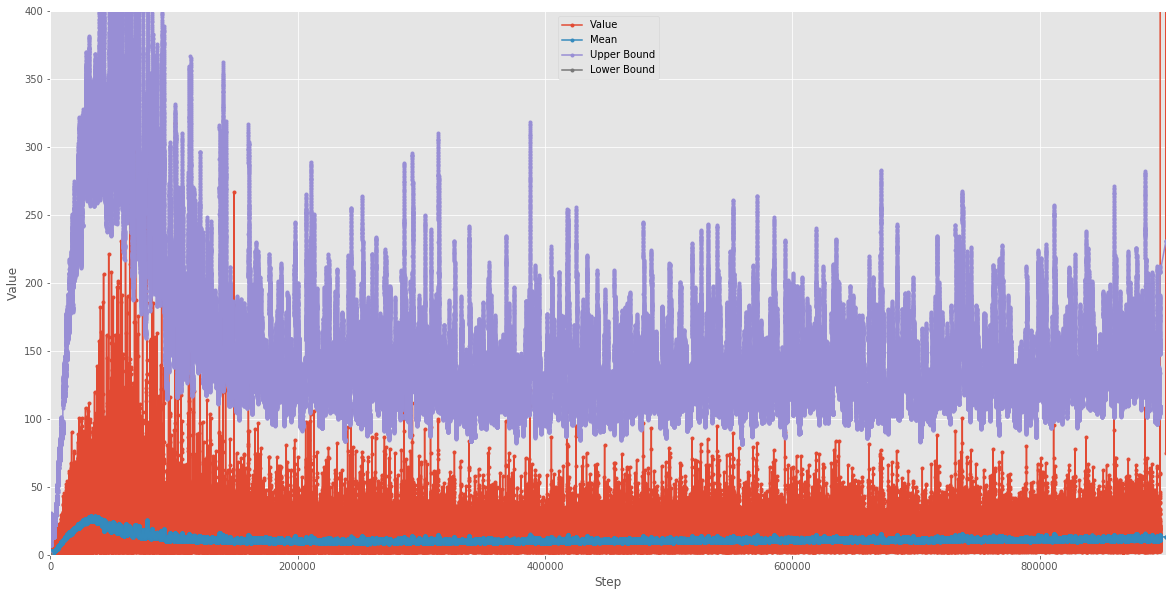

In [60]:
plot(*parameter_norm, sigma=16, beta=0.99)
_ = pyplot.axis([0, parameter_norm[0][-1] + 10, 0, 400])